# Import

In [1]:
# import base pacakges
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # 3D plots
import matplotlib.tri as tri # make surface plot
from pathlib import Path # to extract data from registry
import re # to extract number in name
import scipy.optimize as opt # data fitting
import pandas as pd # data frames
from mpl_toolkits.axes_grid1 import make_axes_locatable # adjust colorbars to axis
from tqdm.notebook import tqdm # loading bar
import ipywidgets as widgets # widgets
from tkinter import Tcl # sort file names

In [2]:
# import custom made pacakges
# directory navigation
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
parentparentdir = os.path.dirname(parentdir)
sys.path.insert(0,parentparentdir) 
# import 
from modules.config import c,d_in,foc,freq,λ,ω_0_in_list,ω_0_in # standard parameters
from modules.beam_waist_functions import cal_ω_0_out_and_d_out, create_plot # theoretical beam waist functions
from modules.heterodyne_functions import I_comb

In [3]:
# # # # # # # Turn off future warnings # # # # # 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Custom parameters

In [4]:
# # Define Physical constants:
# c=2.99792458E11 # in mm/s

# # Define Input Paramters:
# d_in=449.7# in mm
# freq=95E9
# # mirror param:
# foc=339.5
# λ=c/freq
# # manufacturers paramas:
# ω_0_in_list={70:7.85,75:7.67,80:7.47,85:7.26,90:7.03,95:7.16,100:7.23,105:7.26,110:7.24} #GHz:mm
# ω_0_in=ω_0_in_list[min(ω_0_in_list.keys(), key=lambda x:abs(x-freq/1E9))]

# Import data from directory

In [5]:
# path of measurements
p=Path('./Measurements/serious measurements')
# list all main measurement folders
print("Choose folder:")
dir_names=list([x.name for x in p.iterdir() if x.is_dir() and x.name.startswith("Distance")])
menu=widgets.Dropdown(
    options={dir_names[i]:i for i in range(len(dir_names))},
    value=2,
    description='Folder:')
display(menu)

Choose folder:


Dropdown(description='Folder:', index=2, options={'Distance 1250mm': 0, 'Distance 1550mm': 1, 'Distance 1650mm…

In [214]:
paths=list([x for x in p.iterdir() if x.is_dir() and x.name.startswith("Distance")][menu.value].glob('./*.dat'))
# sort path names by frequency
path_names=list(map(lambda x: x.name, paths)) # get path names
    # extract frequencies
pattern=re.compile(r"(\d+)")
freq_list=np.array([pattern.match(x).groups()[0] for x in path_names if x.startswith("Noise")==False]).astype(int)
freq_list=np.sort(freq_list)
    # sort paths
sorted_path_names=np.array(Tcl().call('lsort', '-dict', path_names)) # sorted path names
# hack for sorting lists from short too long (this should be the default)
duplicate_freqs=[x for x in np.unique(freq_list) if list(freq_list).count(x)!=1]
for duplis in duplicate_freqs:
    duplicate_indices=np.where(freq_list==duplis)
    for index in duplicate_indices[0][::-1][:-1]:
        backup=np.copy(sorted_path_names[index-1])
        sorted_path_names[index-1]=sorted_path_names[index]
        sorted_path_names[index]=backup
# sort
_,paths=zip(*sorted(zip([list(sorted_path_names).index(path_name) for path_name in path_names], paths)))
#remember to change name if directory name is changed
data=[]
for path in paths:
    data.append(np.genfromtxt(path,skip_header=1)[:,:3]) #all rows, only the first 3 columns
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))
#extract distance from directory name
pattern=re.compile(r"(\D+)(\d+)")
dir_dist=np.int(pattern.match(dir_names[menu.value]).groups()[1])
# map size and step size
size=np.int(np.sqrt(len(data[0][:,2])))
step_size=step_size=data[0][1][0]-data[0][0][0]

current directory:
Distance 1550mm


# Fitting data (for rescaling plot axis and further processing)

In [215]:
def gaussian_profile(coords,A=1,b=0,x_0=0,y_0=0,σ_x=1,σ_y=1,θ=0,**kwargs):
    if ('popt' in kwargs):
        A,b,x_0,y_0,σ_x,σ_y,θ=popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6]
    a=np.cos(θ)**2/(2*σ_x**2)+np.sin(θ)**2/(2*σ_y**2)
    c=np.sin(2*θ)*(-1/(4*σ_x**2)+1/(4*σ_y**2))
    d=np.sin(θ)**2/(2*σ_x**2)+np.cos(θ)**2/(2*σ_y**2)
    return A*np.exp(-(a*(coords[0]-x_0)**2+2*c*(coords[0]-x_0)*(coords[1]-y_0)+d*(coords[1]-y_0)**2))+b
# Was das Modell nicht berücksichtigt:
    # Auftreffswinkel

In [216]:
# caclulate fits
popt_data=[]
pcov_data=[]
for image in data:
    max_pos=np.where(image[:,2]==np.amax(image[:,2]))
    initial_guess = (np.amax(image),0,np.int(image[max_pos,0]),np.int(image[max_pos,1]),20,20,0)
    popt, pcov = opt.curve_fit(gaussian_profile, (image[:,0], image[:,1]), image[:,2], p0=initial_guess)
    pcov=np.sqrt(np.diag(pcov))
    popt_data.append(popt)
    pcov_data.append(pcov)

# Plot data

current directory:
Distance 1550mm


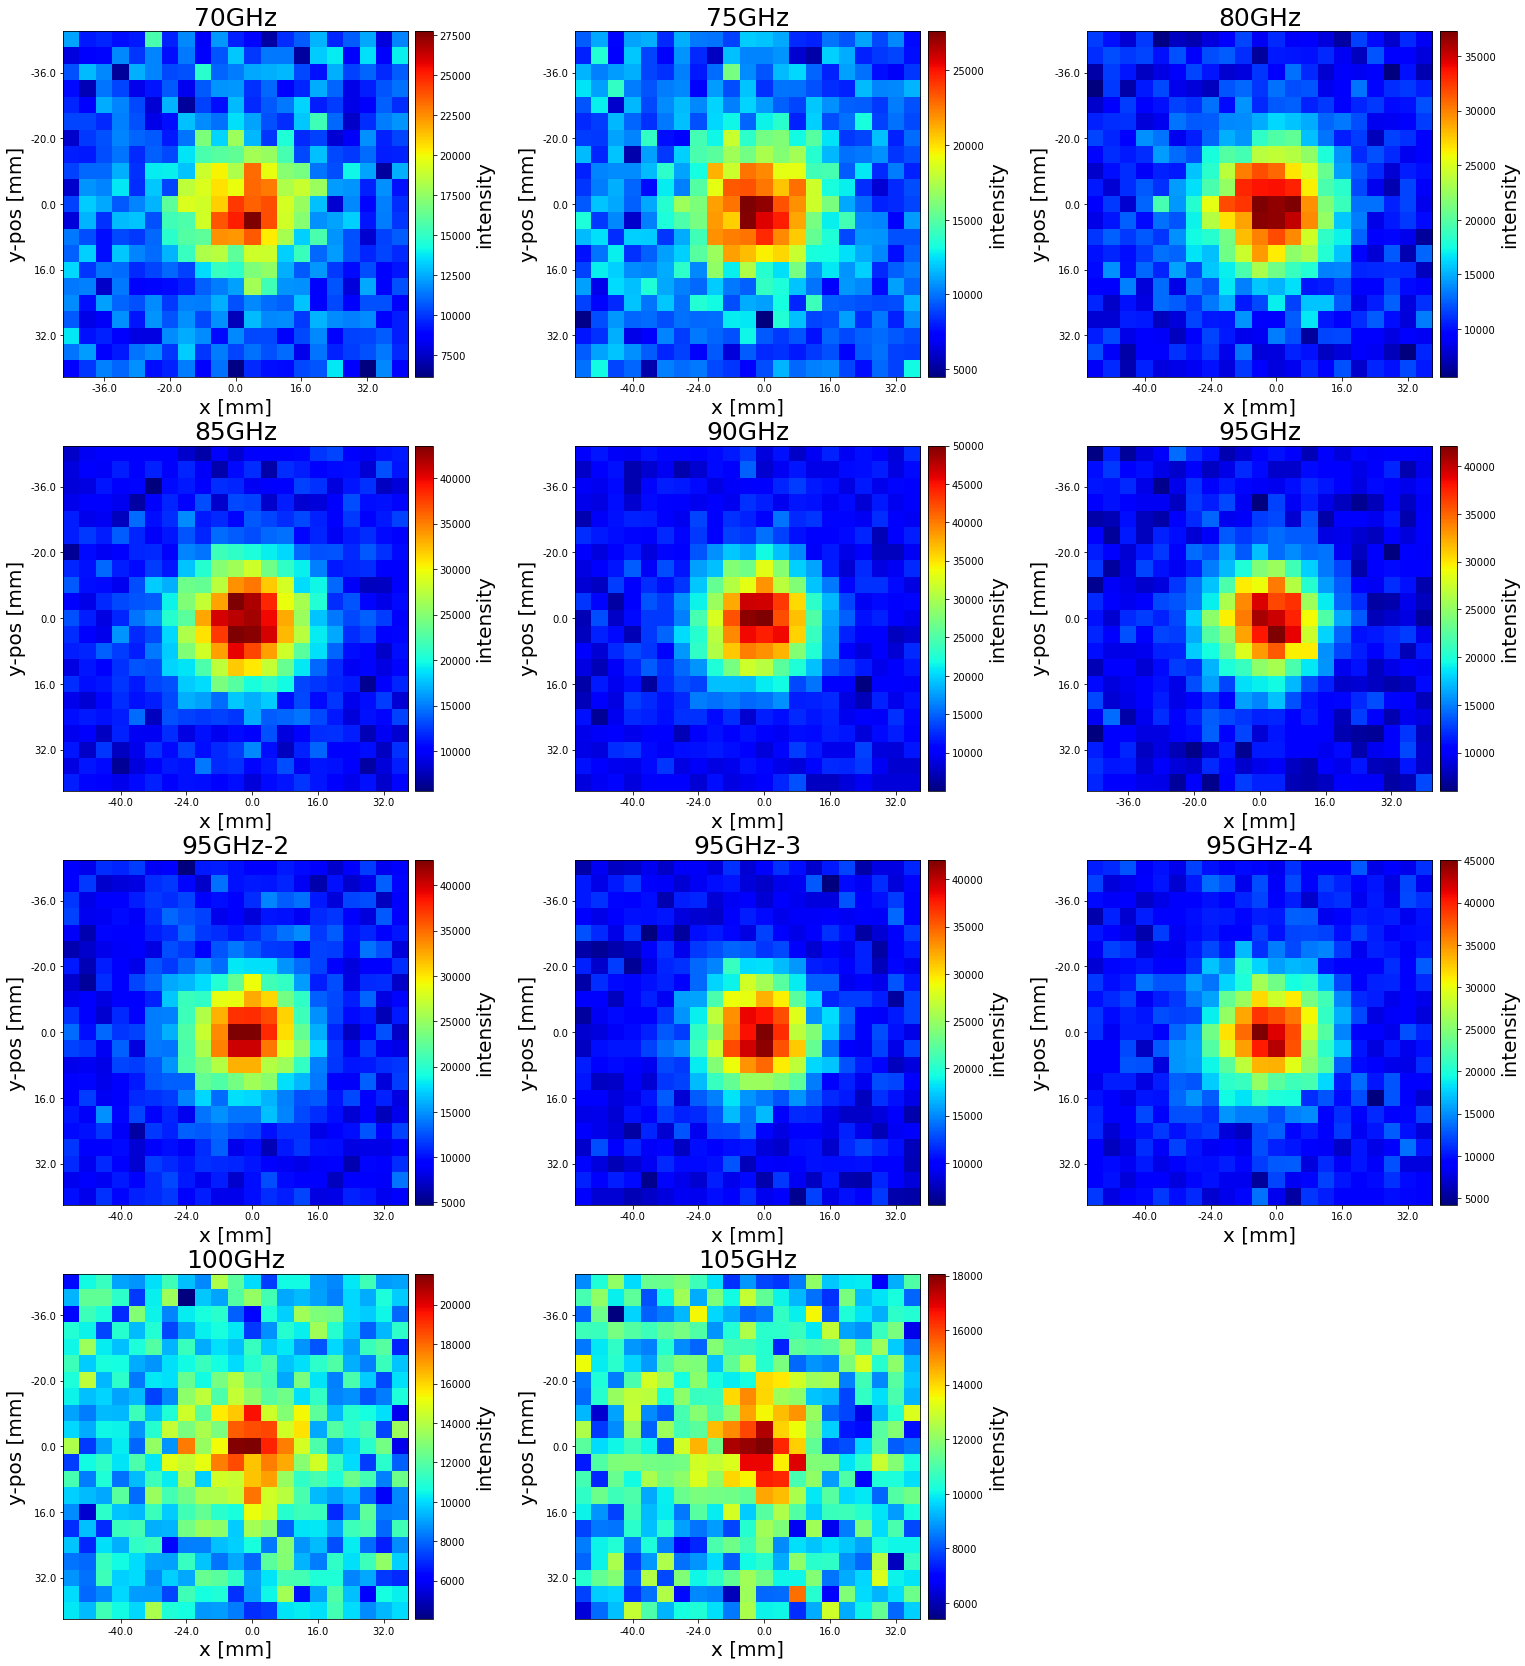

In [217]:
# in test_data
rows=int(len(paths) / 3) + (len(paths) % 3 > 0) # how many rows
# plot
fig = plt.figure(figsize=(26, 7.3*rows))
for i,image in enumerate(data):
    ax=plt.subplot(rows,3,i+1)
    im=ax.imshow(image[:,2].reshape((size,size)),cmap='jet', interpolation='nearest')
    # readjust labels to center
    # find x-peak
    peak_x=min(image[:,0][:size], key=lambda x:abs(x-popt_data[i][2]))
    index_x=list(image[:,0][:size]).index(peak_x)
    # y-peak
    peak_y=min(image[:,1][::size], key=lambda x:abs(x-popt_data[i][3]))
    index_y=list(image[:,1][::size]).index(peak_y)
    # xticks
    x_labs1=list(np.arange(-step_size*(index_x-1),0,step_size)[:-3][::4]) # lower labels
    x_labs2=list(np.arange(0,step_size*(size-index_x),step_size)[::4]) # upper labels
    ax.set_xticklabels(labels=x_labs1+x_labs2) # set labels
    x_ind1=list(np.arange(index_x,-1,-4)[1:][::-1]) # lower indices
    x_ind2=list(np.arange(index_x,size,4)) # upper indices
    ax.set_xticks(x_ind1+x_ind2) # set
    ax.set_xlabel("x [mm]",fontsize=20)
    # yticks
    y_labs1=list(np.arange(-step_size*(index_y-1),0,step_size)[:-3][::4]) # lower labels
    y_labs2=list(np.arange(0,step_size*(size-index_y),step_size)[::4]) # upper labels
    ax.set_yticklabels(labels=y_labs1+y_labs2) # set labels
    y_ind1=list(np.arange(index_y,-1,-4)[1:][::-1]) # lower indices
    y_ind2=list(np.arange(index_y,size,4)) # upper indices
    ax.set_yticks(y_ind1+y_ind2) # set indices
    ax.set_ylabel("y-pos [mm]",fontsize=20)
    ax.set_title(paths[i].name[:-4],fontsize=25)
    #adjust colorbar to plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar=plt.colorbar(im, cax=cax)
    cbar.ax.set_ylabel('intensity',fontsize=20)
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))

# Export

plt.savefig("Images/beam_maps/beam_maps_{}mm.png".format(dir_dist), bbox_inches='tight')

# Project find beam profile

current directory:
Distance 1550mm


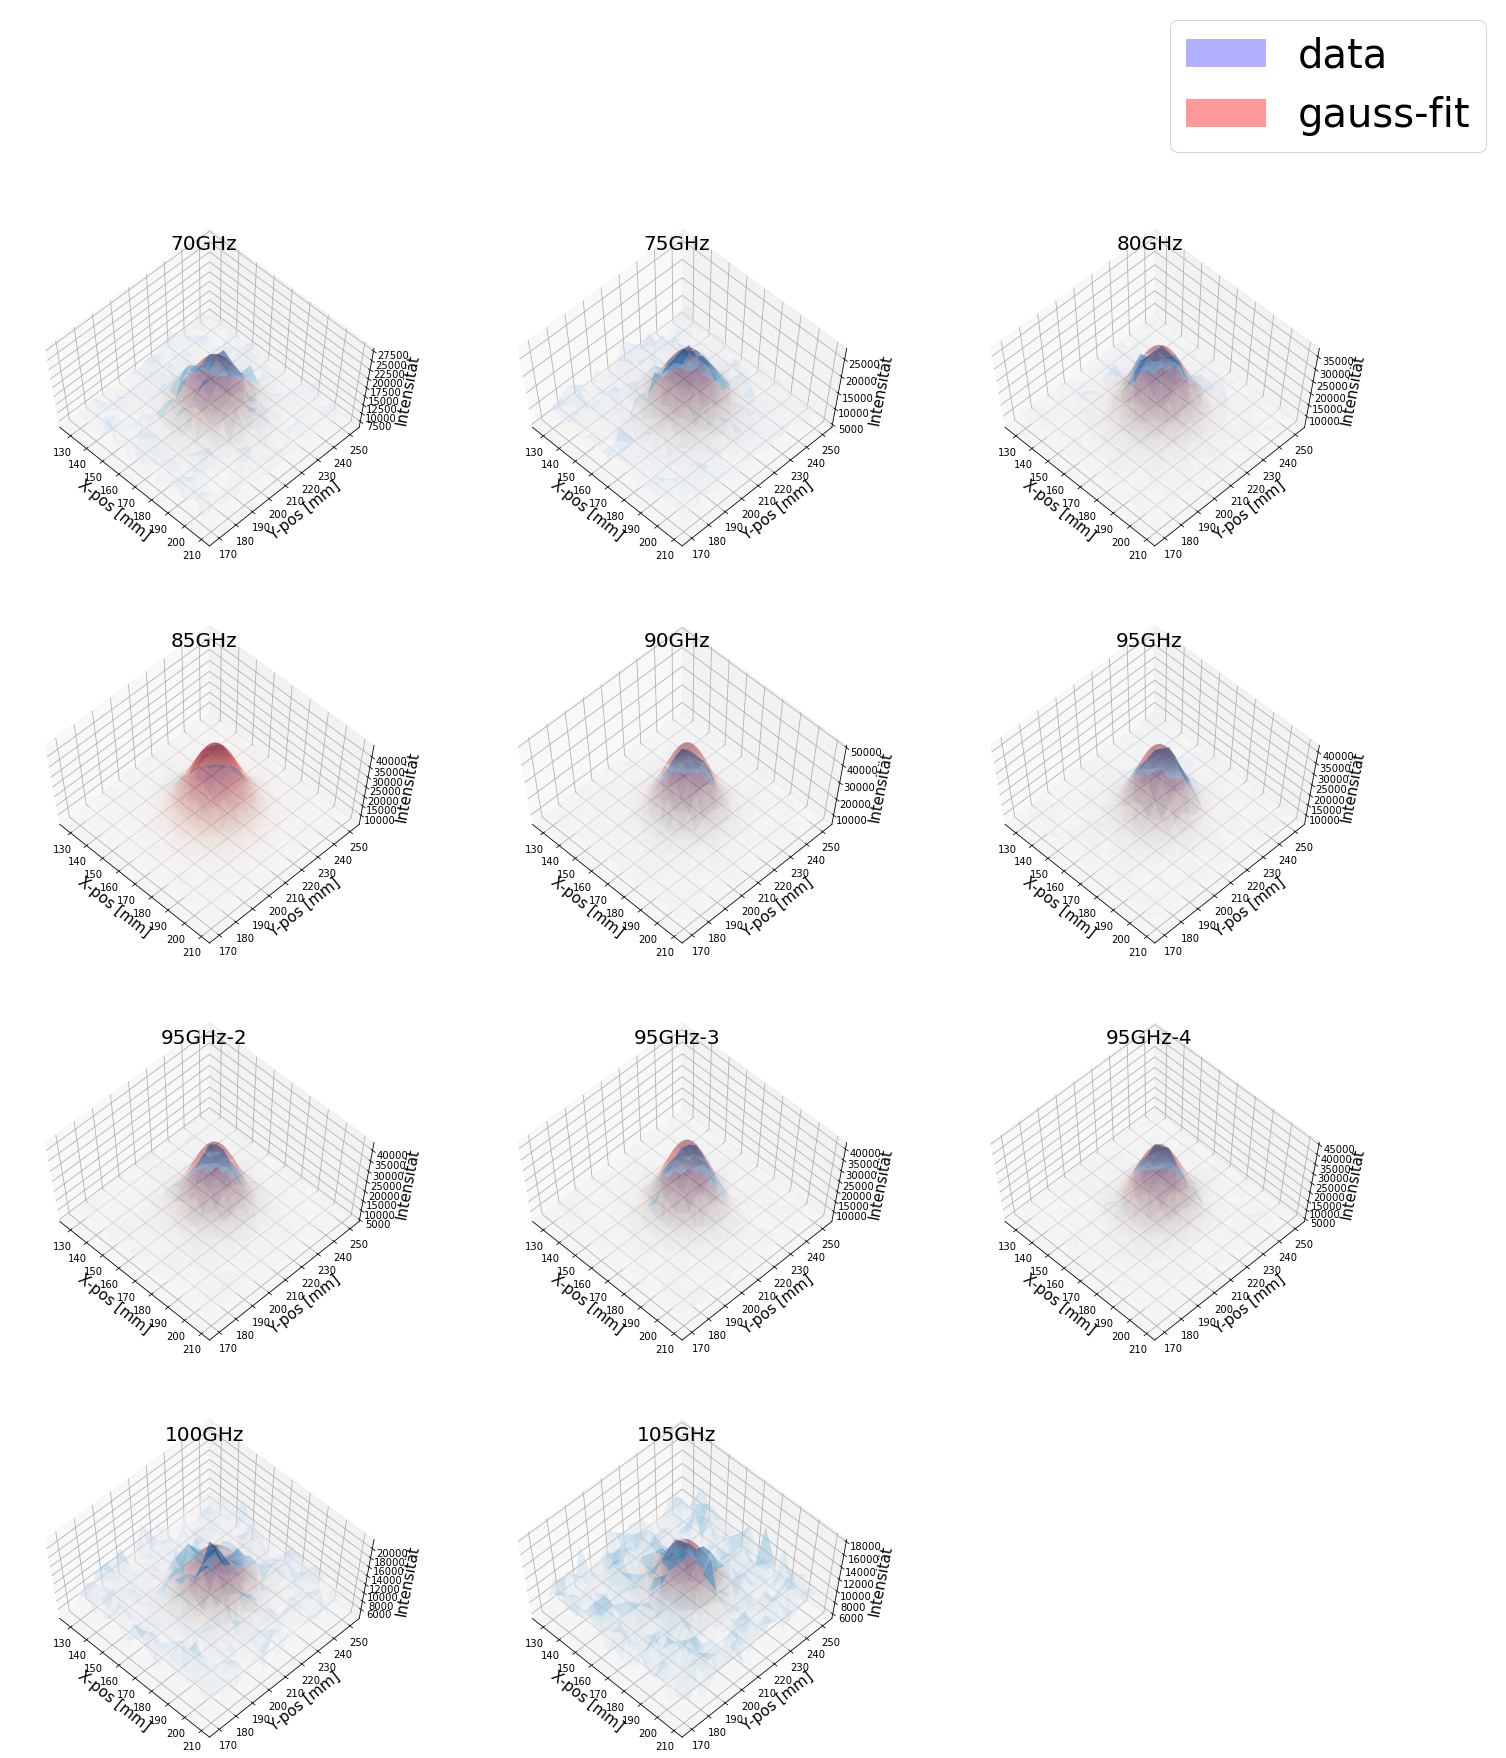

In [218]:
# plot the fits and functions in 3D (in coords space)
rows=int(len(popt_data) / 3) + (len(popt_data) % 3 > 0) # how many rows
fig = plt.figure(figsize=(24,rows*7))

for i,(popt,image) in enumerate(zip(popt_data,data)):
    X=np.linspace(np.amin(image[:,0]),np.amax(image[:,0]),50)
    Y=np.linspace(np.amin(image[:,1]),np.amax(image[:,1]),50)
    X_grid,Y_grid=np.meshgrid(X,Y)
    #plot
    ax = fig.add_subplot(rows,3,i+1, projection='3d')
    ax.set_xlabel('X-pos [mm]', fontsize=15)
    ax.set_ylabel('Y-pos [mm]', fontsize=15)
    ax.set_zlabel('Intensität', fontsize=15)
    Z=[gaussian_profile((x,y),popt=popt) for x in X for y in Y]
    ax.plot_trisurf(image[:,0], image[:,1], image[:,2], cmap='Blues',alpha=0.3)
    ax.plot_trisurf(X_grid.ravel(), Y_grid.ravel(), Z, cmap='Reds',alpha=0.4 )
    ax.set_title(paths[i].name[:-4], fontsize=20)
# legend
    blue_proxy = plt.Rectangle((0, 0), 1, 1, fc="Blue",alpha=0.3)
    red_proxy = plt.Rectangle((0, 0), 1, 1, fc="red",alpha=0.4)
    ax.view_init(65,-45) #angle of view
fig.legend([blue_proxy,red_proxy],['data','gauss-fit'],loc=1,prop={"size":40})
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))

# export

plt.savefig("Images/Gauss_fits_3D/Gauss_fits_3D_{}mm.png".format(dir_dist), bbox_inches='tight')

current directory:
Distance 1550mm


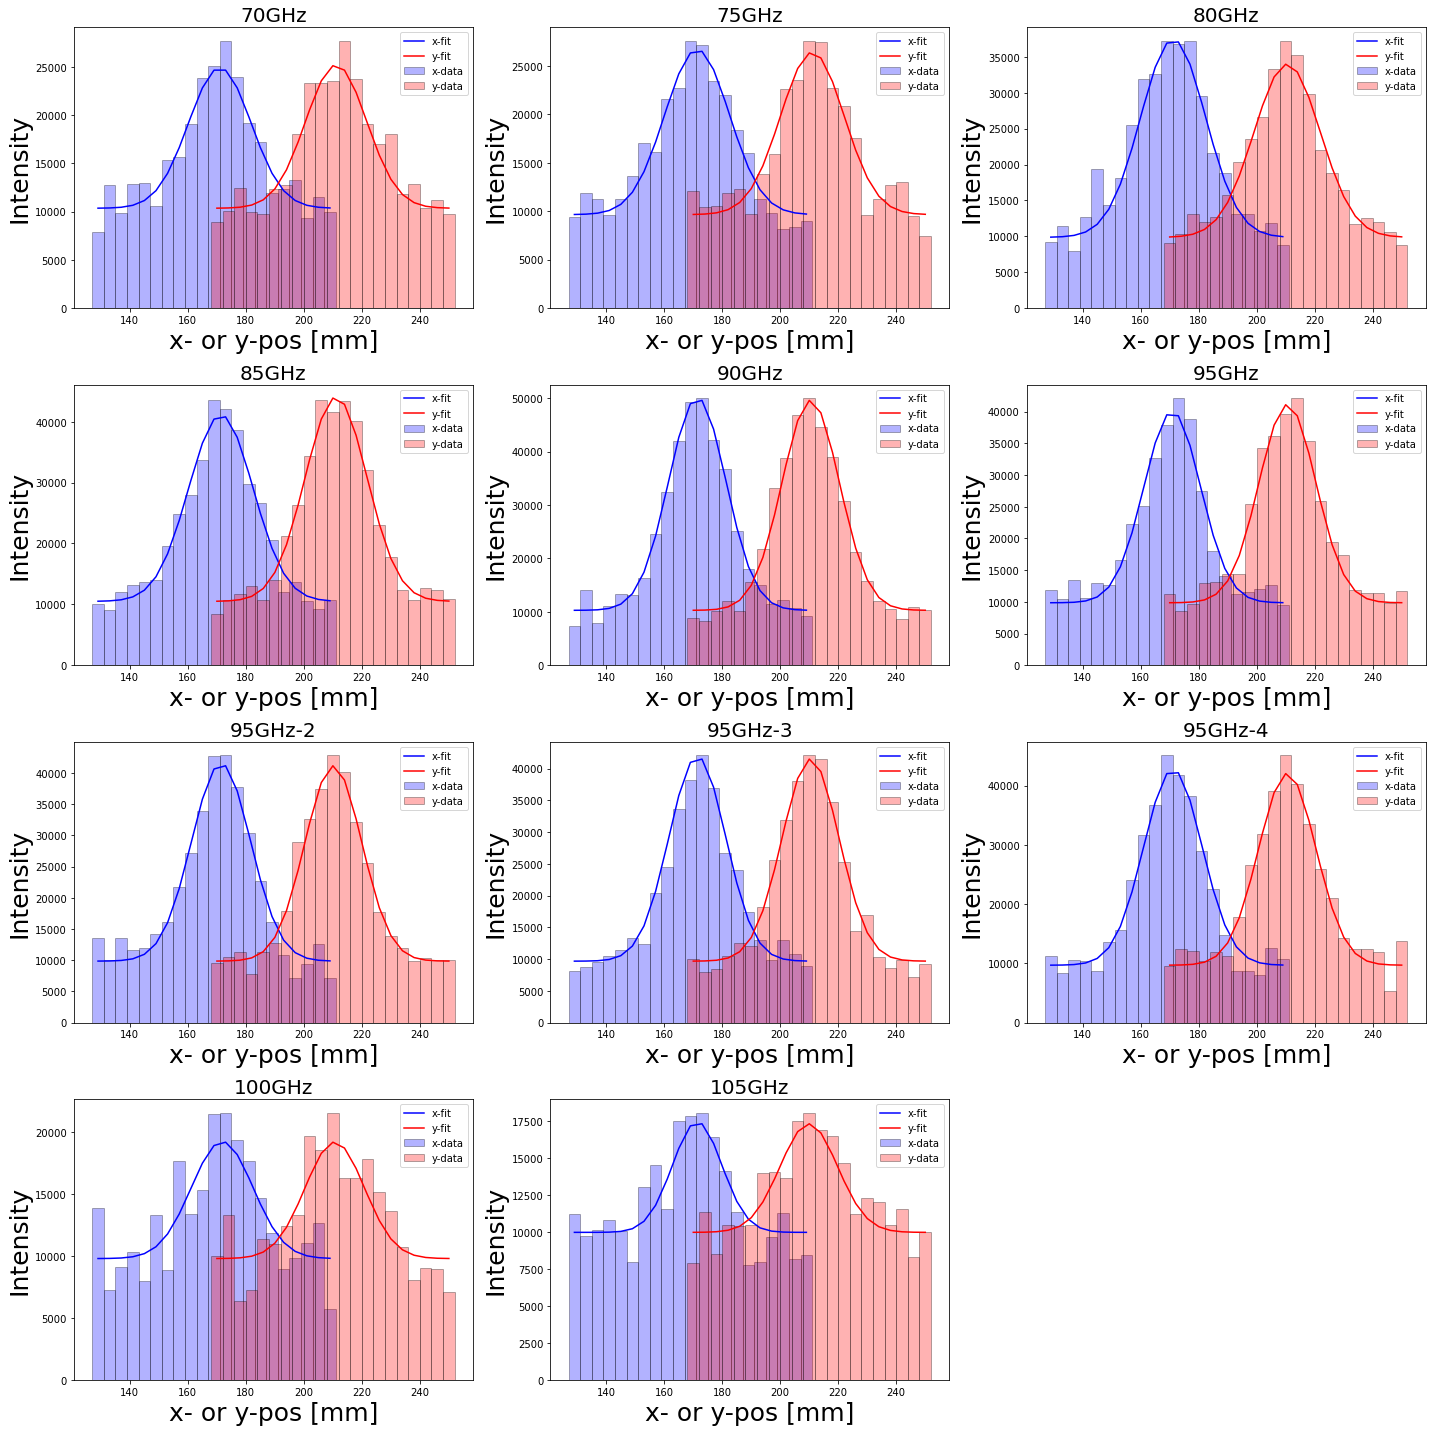

In [219]:
# plot the fits and functions
rows=int(len(popt_data) / 3) + (len(popt_data) % 3 > 0) # how many rows
fig = plt.figure(figsize=(20,rows*5))

for i,(popt,image) in enumerate(zip(popt_data,data)):
    #max positions
    max_pos=np.where(image[:,2]==np.amax(image[:,2]))[0][0]
    x_max=np.int(image[:,0][max_pos])
    y_max=np.int(image[:,1][max_pos])
    #plot
    ax = fig.add_subplot(rows,3,i+1)
    ax.set_xlabel('x- or y-pos [mm]', fontsize=25)
    ax.set_ylabel('Intensity', fontsize=25)
    ax.set_title(paths[i].name[:-4], fontsize=20)
    # x-plot
    X_vals=image[:,0][np.where(image[:,1]==y_max)]
    X_ints=image[:,2][np.where(image[:,1]==y_max)]
    X_fit=[gaussian_profile((x,y_max),popt=popt) for x in X_vals]
    plt.bar(X_vals,X_ints,width=4,color="blue",edgecolor="black",alpha=0.3,label="x-data")
    plt.plot(X_vals,X_fit,color="blue",label="x-fit")
    # y_plot
    Y_vals=image[:,1][np.where(image[:,0]==x_max)]
    Y_ints=image[:,2][np.where(image[:,0]==x_max)]
    Y_fit=[gaussian_profile((x_max,y),popt=popt) for y in Y_vals]
    plt.bar(Y_vals,Y_ints,width=4,color="red",edgecolor="black",alpha=0.3,label="y-data")
    plt.plot(Y_vals,Y_fit,color="red",label="y-fit")
    plt.legend(prop={"size":10})
plt.tight_layout()
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))

# export

plt.savefig("Images/Gauss_fits_xy/Gauss_fits_xy_{}mm.png".format(dir_dist), bbox_inches='tight')

In [220]:
# create Pandas DataFrame
popt_array=np.array(popt_data)
pcov_array=np.array(pcov_data)
total_array=np.zeros(shape=(popt_array.shape[0],popt_array.shape[1]*2))
for i in range(0,total_array.shape[1]):
    if i%2==0:
        total_array[:,i]=popt_array[:,np.int(i/2)]
    else:
        total_array[:,i]=pcov_array[:,np.int((i-1)/2)]
#DataFrame initialization
fit_results=pd.DataFrame(total_array,index=list(map(lambda x: x.name[:-4], paths)),
                     columns=["A","ΔA","b","Δb","x_0","Δx_0","y_0","Δy_0","σ_x","Δσ_x","σ_y","Δσ_y","θ","Δθ"]).round(decimals=2)
fit_results["θ"],fit_results["Δθ"]=(fit_results["θ"]%(2*np.pi)).round(decimals=2),(fit_results["Δθ"]%(2*np.pi)).round(decimals=2)
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))

fit_results

current directory:
Distance 1550mm


,A,ΔA,b,Δb,x_0,Δx_0,y_0,Δy_0,σ_x,Δσ_x,σ_y,Δσ_y,θ,Δθ
70GHz,15139.24,500.00,10345.22,103.17,170.99,0.36,211.12,0.35,10.55,0.38,10.79,0.39,4.62,1.03
75GHz,17135.99,501.86,9639.03,110.29,171.28,0.33,210.99,0.32,11.25,0.36,10.90,0.35,0.55,0.66
80GHz,27659.70,503.07,9845.34,115.29,171.17,0.20,210.69,0.21,11.55,0.23,11.13,0.22,1.09,0.35
85GHz,34196.34,480.44,10491.13,102.76,171.12,0.16,211.01,0.15,11.26,0.17,10.56,0.16,3.59,0.15
90GHz,39900.10,551.08,10274.74,101.28,171.36,0.14,210.56,0.14,10.11,0.15,9.74,0.14,3.96,0.26
95GHz,32038.88,561.09,9851.71,101.03,170.89,0.17,210.63,0.17,9.77,0.18,9.82,0.18,5.88,2.23
95GHz-2,31716.02,547.90,9846.27,101.97,171.43,0.18,210.21,0.17,9.78,0.18,10.24,0.19,1.90,0.27
95GHz-3,32299.66,547.21,9663.36,99.21,171.39,0.17,210.46,0.17,9.88,0.18,9.79,0.18,1.18,1.32
95GHz-4,33099.90,567.13,9675.36,105.29,171.08,0.17,210.47,0.17,10.26,0.19,9.73,0.18,3.79,0.23
100GHz,9472.44,523.82,9789.88,104.46,171.82,0.59,210.65,0.57,10.66,0.63,10.26,0.61,3.15,1.03


In [221]:
# In the following we assume that σ_x=σ_y und therefore take the average:
total_results=pd.DataFrame([(fit_results["σ_x"]+fit_results["σ_y"])/2,
                            np.sqrt((fit_results["Δσ_x"]**2+fit_results["Δσ_y"]**2))/2],
                           index=["σ","Δσ"]).T.round(decimals=2)
total_results["ω_z"]=2*total_results["σ"]
total_results["Δω_z"]=2*total_results["Δσ"]
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))

total_results

current directory:
Distance 1550mm


,σ,Δσ,ω_z,Δω_z
70GHz,10.67,0.27,21.34,0.54
75GHz,11.08,0.25,22.16,0.50
80GHz,11.34,0.16,22.68,0.32
85GHz,10.91,0.12,21.82,0.24
90GHz,9.93,0.10,19.86,0.20
95GHz,9.80,0.13,19.60,0.26
95GHz-2,10.01,0.13,20.02,0.26
95GHz-3,9.84,0.13,19.68,0.26
95GHz-4,10.00,0.13,20.00,0.26
100GHz,10.46,0.44,20.92,0.88


# Comparison of theory and experiment

## Calculate error bars numerically

In [222]:
# Error bars

# find all frequencies in our data
frequencies=np.unique(freq_list) # in GHz
# error bars
# # # # # # # #
d_in_err=10
d_mirr_device=15
X_err=np.sqrt((d_in_err)**2+(d_mirr_device)**2)
foc_err=0
freq_err=1.25
err_points=11
# only heterodyne
band=20
X_b=[1/(2*band)]*(2*band)
# # # # # # # # 
X_bar=np.unique(np.linspace(dir_dist-X_err,dir_dist+X_err,err_points))
d_in_bar=np.unique(np.linspace(d_in-d_in_err,d_in+d_in_err,err_points))
foc_bar=np.unique(np.linspace(foc-foc_err,foc+foc_err,err_points))
error_area_single=np.zeros((len(X_bar)*len(d_in_bar)*len(np.linspace(freq-freq_err,freq+freq_err,err_points)),len(frequencies)))
error_area_double=np.copy(error_area_single)
# # # # # # # #
for i,freq in tqdm(enumerate(frequencies),total=len(frequencies),desc="progress"):
    j=0
    freq_bar=np.unique(np.linspace(freq-freq_err,freq+freq_err,err_points))
    temp_bool=False
    if len(X_bar)==1: temp_bool=True
    for err_X in tqdm(X_bar,leave=False, desc="X"):
        temp_bool=False
        if len(d_in_bar)==1: temp_bool=True
        for err_d_in in tqdm(d_in_bar, leave=False,disable=temp_bool, desc="d_in"):
            temp_bool=False
            if len(foc_bar)==1: temp_bool=True
            for err_foc in tqdm(foc_bar,leave=False,disable=temp_bool, desc="foc"):
                temp_bool=False
                if len(freq_bar)==1: temp_bool=True
                for err_freq in tqdm(freq_bar,leave=False, disable=temp_bool, desc="freq"):
                    # single frequency
                    error_area_single[j,i]=create_plot(X=err_X, d_in=err_d_in,ω_0_in=ω_0_in_list[min(ω_0_in_list.keys(), key=lambda x:abs(x-err_freq))],foc=err_foc,λ=c/(err_freq*1E9))
                    # double frequency
                    X_a=list(np.linspace(err_freq-6.35-1.25,err_freq-6.35+1.25,band)) + list(np.linspace(err_freq+6.35-1.25,err_freq+6.35+1.25,band))
                    error_area_double[j,i]=I_comb(err_X, f_list=X_a, A_0_list=X_b,d_in=err_d_in,foc=err_foc,c=c,ω_0_in_list=ω_0_in_list)
                    # external counter
                    j+=1
# no error
    # single freq
Y_single=[create_plot(X=dir_dist, d_in=d_in,ω_0_in=ω_0_in_list[min(ω_0_in_list.keys(), key=lambda x:abs(x-freq))],foc=foc,λ=c/(freq*1E9)) for freq in frequencies]
    # double freq
X_a=[list(np.linspace(x-6.35-1.25,x-6.35+1.25,band))+list(np.linspace(x+6.35-1.25,x+6.35+1.25,band)) for x in frequencies]
X_b=[[1/len(X_a[0])]*len(X_a[0])]*len(X_a)
Y_double=[I_comb(dir_dist, f_list=X_a[i], A_0_list=X_b[i],d_in=d_in,foc=foc,c=c,ω_0_in=ω_0_in) for i in tqdm(range(len(X_a)),leave=False)]
# extract higher and lower error
    # single freq
Y_single_upper_err=error_area_single.max(axis=0)-Y_single
Y_single_lower_err=Y_single-error_area_single.min(axis=0)
    # double freq
Y_double_upper_err=error_area_double.max(axis=0)-Y_double
Y_double_lower_err=Y_double-error_area_double.min(axis=0)

# Plot

### Comp LO-freq

current directory:
Distance 1550mm


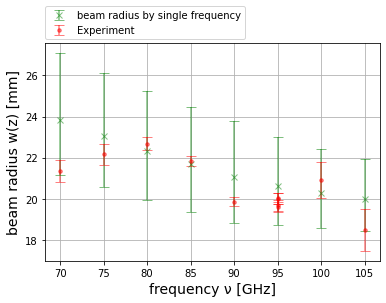

In [226]:
# plot
ax= plt.subplot(1,1,1)
# Single frequency (LO osciallator) theory
ax.errorbar(frequencies,Y_single, yerr=[Y_single_lower_err,Y_single_upper_err],linestyle=" ", capsize=5, marker="x",
            color="green", alpha=0.5, label="beam radius by single frequency")
# Experiment
ax.errorbar(freq_list,np.array(total_results["ω_z"]),linestyle="",markersize=7,
             yerr=np.array(total_results["Δω_z"]), color="red",alpha=0.5,marker=".",capsize=5,label="Experiment")
# formatting
ax.set_xlabel("frequency ν [GHz]",fontsize=14)
ax.set_ylabel("beam radius w(z) [mm]",fontsize=14)
ax.grid(True) # activate grid in plot
plt.legend(bbox_to_anchor=(0, 1.17), loc='upper left', borderaxespad=0.)
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))

# Export
plt.savefig("Images/comp_standard/comp_standard_{}mm.png".format(dir_dist), bbox_inches='tight')

### Compy double sideband

current directory:
Distance 1550mm


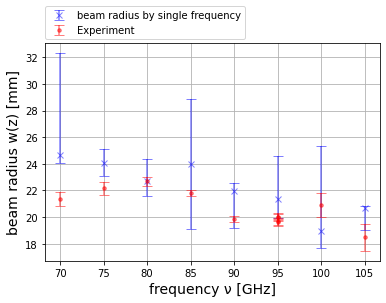

In [227]:
# plot
ax= plt.subplot(1,1,1)
# Single frequency (LO osciallator) theory
ax.errorbar(frequencies,Y_double, yerr=[Y_double_lower_err,Y_double_upper_err],linestyle=" ", capsize=5, marker="x",
            color="blue", alpha=0.5, label="beam radius by single frequency")
# Experiment
ax.errorbar(freq_list,np.array(total_results["ω_z"]),linestyle="",markersize=7,
             yerr=np.array(total_results["Δω_z"]), color="red",alpha=0.5,marker=".",capsize=5,label="Experiment")
# formatting
ax.set_xlabel("frequency ν [GHz]",fontsize=14)
ax.set_ylabel("beam radius w(z) [mm]",fontsize=14)
ax.grid(True) # activate grid in plot
plt.legend(bbox_to_anchor=(0, 1.17), loc='upper left', borderaxespad=0.)
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))

# Export
plt.savefig("Images/comp_heterodyne/comp_heterodyne_{}mm.png".format(dir_dist), bbox_inches='tight')

### Comp both

current directory:
Distance 1550mm


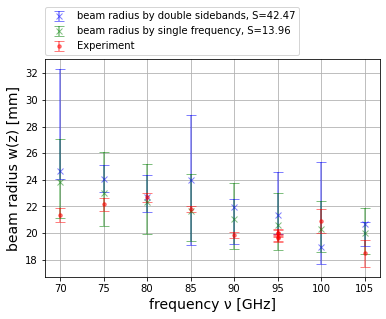

In [228]:
# fitting least sqaure metric
Y_single_S=sum([(np.array(total_results["ω_z"])[i]-dict(zip(frequencies,Y_single))[frq])**2 for i,frq in enumerate(freq_list)])
Y_double_S=sum([(np.array(total_results["ω_z"])[i]-dict(zip(frequencies,Y_double))[frq])**2 for i,frq in enumerate(freq_list)])

# plot
ax= plt.subplot(1,1,1)
# Heterodyne theory
ax.errorbar(frequencies,Y_double, yerr=[Y_double_lower_err,Y_double_upper_err], linestyle=" ", capsize=5, marker="x",
            color="blue",alpha=0.5, label="beam radius by double sidebands, S={:.2f}".format(Y_double_S))
# Single frequency (LO osciallator) theory
ax.errorbar(frequencies,Y_single, yerr=[Y_single_lower_err,Y_single_upper_err],linestyle=" ", capsize=5, marker="x",
            color="green", alpha=0.5, label="beam radius by single frequency, S={:.2f}".format(Y_single_S))
# Experiment
ax.errorbar(freq_list,np.array(total_results["ω_z"]),linestyle="",markersize=7,
             yerr=np.array(total_results["Δω_z"]), color="red",alpha=0.5,marker=".",capsize=5,label="Experiment")
# formatting
ax.set_xlabel("frequency ν [GHz]",fontsize=14)
ax.set_ylabel("beam radius w(z) [mm]",fontsize=14)
ax.grid(True) # activate grid in plot
plt.legend(bbox_to_anchor=(0, 1.24), loc='upper left', borderaxespad=0.)
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))

# Export
plt.savefig("Images/comp_both/comp_both_{}mm.png".format(dir_dist), bbox_inches='tight')